# Logistic Regreesion
## Make Circle Dataset

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

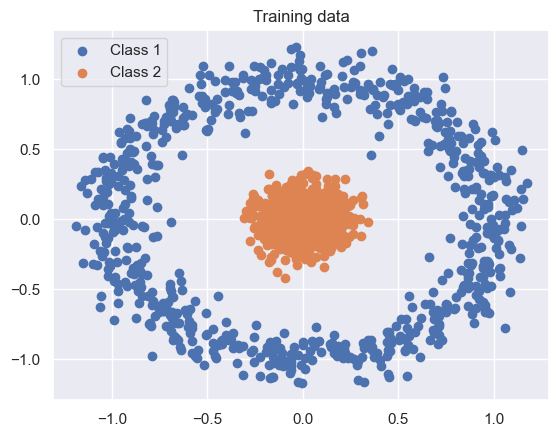

In [3]:
sns.set()
np.random.seed(0)

x, y = make_circles(1500, factor=0.1, noise=0.1)
#logistic
y[np.where(y==-1)] = 0

fig, ax = plt.subplots()
ax.scatter(x[np.where(y==0),0], x[np.where(y==0),1], label='Class 1')
ax.scatter(x[np.where(y==1),0], x[np.where(y==1),1], label='Class 2')
ax.set_title('Training data')
ax.legend();

In [4]:
x, X_test, y, y_test = train_test_split(x, y, test_size=250, random_state=1)
x, X_val, y, y_val = train_test_split(x, y, test_size=250, random_state=1)
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

In [5]:
class LogReg(torch.nn.Module):
    def __init__(self, X,kernel='linear',gamma=1.0,gammaGrad=True,p=2):
        super().__init__()
        assert kernel in ['linear', 'rbf', 'poly']
        self.X = X
        
        if kernel == 'linear':
            self._kernel = self.linear
            self._num_c = self.X.shape[1]
        elif kernel == 'rbf':
            self._kernel = self.rbf
            self._num_c = x.size(0)
            self._gamma = torch.nn.Parameter(torch.FloatTensor([gamma]),
                                             requires_grad=gammaGrad)
        
        elif kernel == 'poly':
            self._p=p
            self._kernel = self.poly
            self._num_c = x.size(0) 
           
        else:
            assert False
            
        self._w = torch.nn.Linear(in_features=self._num_c, out_features=1)

    def rbf(self, x, gamma=1):
        y = self.X.repeat(x.size(0), 1, 1)
        return torch.exp(-self._gamma*((x[:,None]-y)**2).sum(dim=2))

    def poly(self, x, c=1):
        y = self.X.repeat(x.size(0), 1, 1)
        return ((x@(self.X.T))+c) ** self._p     
    
    @staticmethod
    def linear(x):
        return x

    def forward(self, x):
        y = self._kernel(x)
        y = self._w(y)
        #For Logistic we use Sigmoid
        return torch.sigmoid(y)
    
    def train(self,x,y,X_val,y_val,epochs=1000):
        valat=epochs/10
        optim=torch.optim.SGD(self.parameters(),lr=0.01)
        criterion = torch.nn.BCELoss()
        for i in range(epochs):
            optim.zero_grad()
            pred=self(x)
            loss=criterion(pred,y.unsqueeze(1))
            loss.backward()
            optim.step()
            ypred=self(X_val).detach()
            ypred=ypred.transpose(1,0).reshape(y_val.shape).numpy()
            #For logistic our threshold changes from case of SVM [0,(-1,1)] to [0.5,(0,1)]
            ypred[np.where(ypred<0.5)]=0
            ypred[np.where(ypred>=0.5)]=1
            if i%valat==0:
                print("Validation Accuracy at epoch",i,":",accuracy_score(y_val,ypred))
        print("Training Loss is :",loss.item())
    def test(self,x_test,y_test):
        ypred=self(x_test).detach()
        ypred=ypred.transpose(1,0).reshape(y_test.shape).numpy()
        ypred[np.where(ypred<0.5)]=0
        ypred[np.where(ypred>=0.5)]=1
        print("Test Accuracy:",accuracy_score(y_test,ypred))

def plotLog(model_linear,x,y,title):
    grid_x, grid_y = torch.meshgrid(torch.arange(x.min()*1.1, x.max()*1.1, step=0.1),
                                    torch.arange(x.min()*1.1, x.max()*1.1, step=0.1))
    x_test_grid = torch.stack((grid_x, grid_y)).reshape(2, -1).transpose(1,0)

    y_test_linear = model_linear(x_test_grid).detach()

    y_test_linear = y_test_linear.transpose(1,0).reshape(grid_x.shape).numpy()
    



    fig, ax = plt.subplots(1,1, figsize=(10,10))

    cs0 = ax.contourf(grid_x.numpy(), grid_y.numpy(), y_test_linear,cmap="Purples")
    ax.contour(cs0, '--', levels=[0.5], colors='tab:green', linewidths=2)

    ax.plot(np.nan, label='decision boundary', color='tab:green')
    ax.scatter(x[np.where(y==0),0], x[np.where(y==0),1])

    ax.scatter(x[np.where(y==1),0], x[np.where(y==1),1])
    ax.legend()
    ax.set_title(title)


In [6]:
linLog=LogReg(x,kernel='linear')
linLog.train(x,y,X_val,y_val)
linLog.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.516
Validation Accuracy at epoch 100 : 0.464
Validation Accuracy at epoch 200 : 0.424
Validation Accuracy at epoch 300 : 0.392
Validation Accuracy at epoch 400 : 0.376
Validation Accuracy at epoch 500 : 0.344
Validation Accuracy at epoch 600 : 0.308
Validation Accuracy at epoch 700 : 0.288
Validation Accuracy at epoch 800 : 0.28
Validation Accuracy at epoch 900 : 0.316
Training Loss is : 0.6931471824645996
Test Accuracy: 0.348


In [7]:
polyLog=LogReg(x,kernel='poly',p=2)
polyLog.train(x,y,X_val,y_val)
polyLog.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.52
Validation Accuracy at epoch 100 : 1.0
Validation Accuracy at epoch 200 : 1.0
Validation Accuracy at epoch 300 : 1.0
Validation Accuracy at epoch 400 : 1.0
Validation Accuracy at epoch 500 : 1.0
Validation Accuracy at epoch 600 : 1.0
Validation Accuracy at epoch 700 : 1.0
Validation Accuracy at epoch 800 : 1.0
Validation Accuracy at epoch 900 : 1.0
Training Loss is : 0.016199272125959396
Test Accuracy: 1.0


In [8]:
rbfLog=LogReg(x,kernel='rbf')
rbfLog.train(x,y,X_val,y_val)
rbfLog.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.48
Validation Accuracy at epoch 100 : 1.0
Validation Accuracy at epoch 200 : 1.0
Validation Accuracy at epoch 300 : 1.0
Validation Accuracy at epoch 400 : 1.0
Validation Accuracy at epoch 500 : 1.0
Validation Accuracy at epoch 600 : 1.0
Validation Accuracy at epoch 700 : 1.0
Validation Accuracy at epoch 800 : 1.0
Validation Accuracy at epoch 900 : 1.0
Training Loss is : 0.012579984962940216
Test Accuracy: 1.0


/Users/anudeep/Library/Python/3.9/lib/python/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/kr/tmv0s2jx5nzbfv914ndj8tq00000gn/T/ipykernel_60344/1237629433.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  ax.scatter(x[np.where(y==0),0], x[np.where(y==0),1])


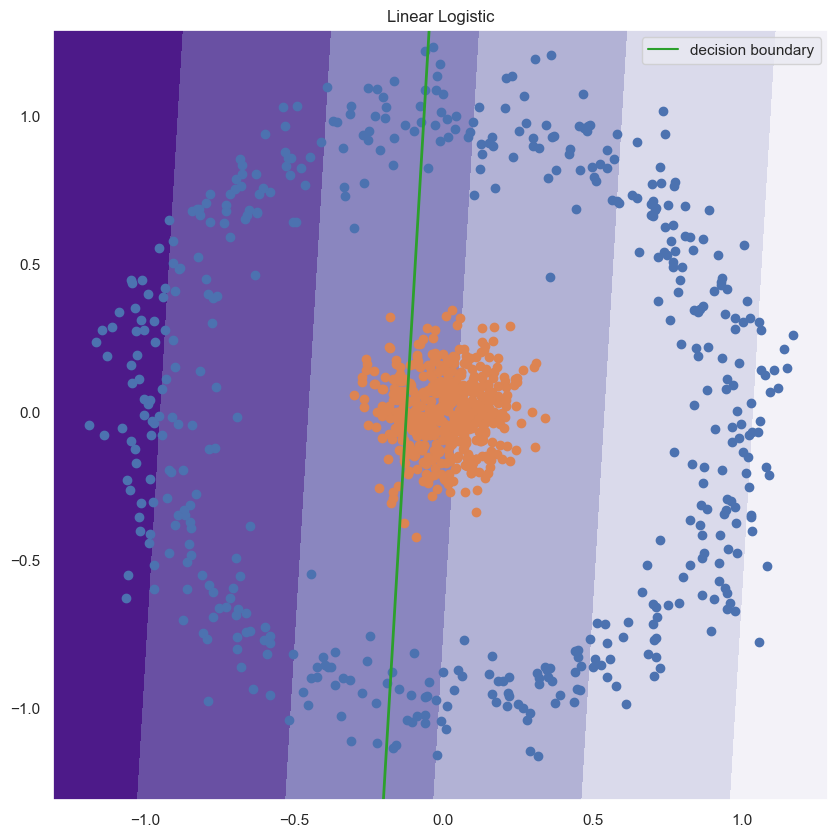

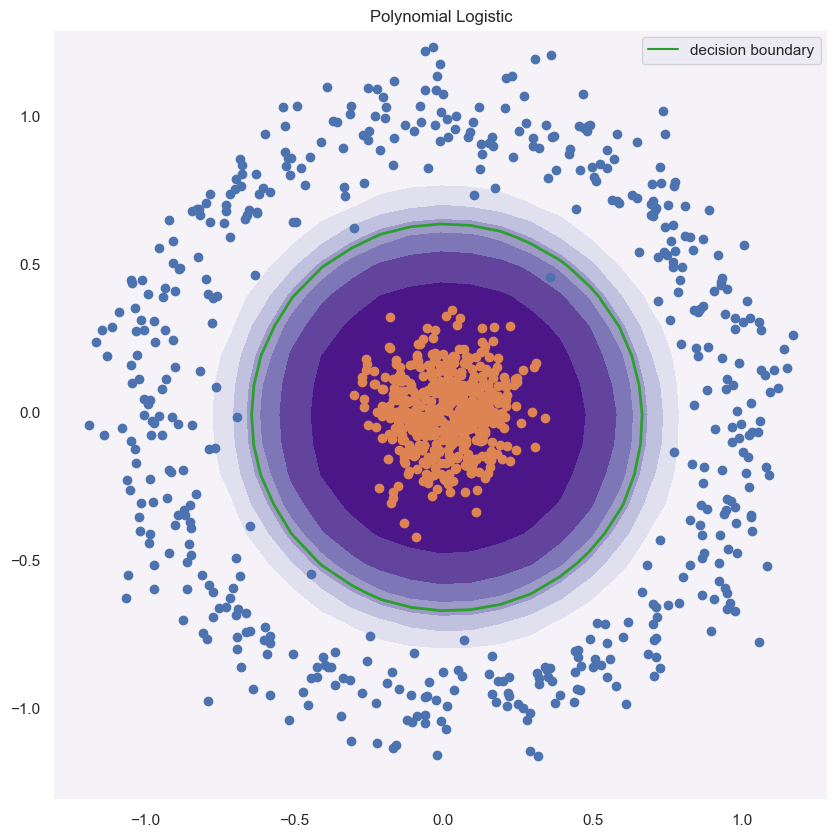

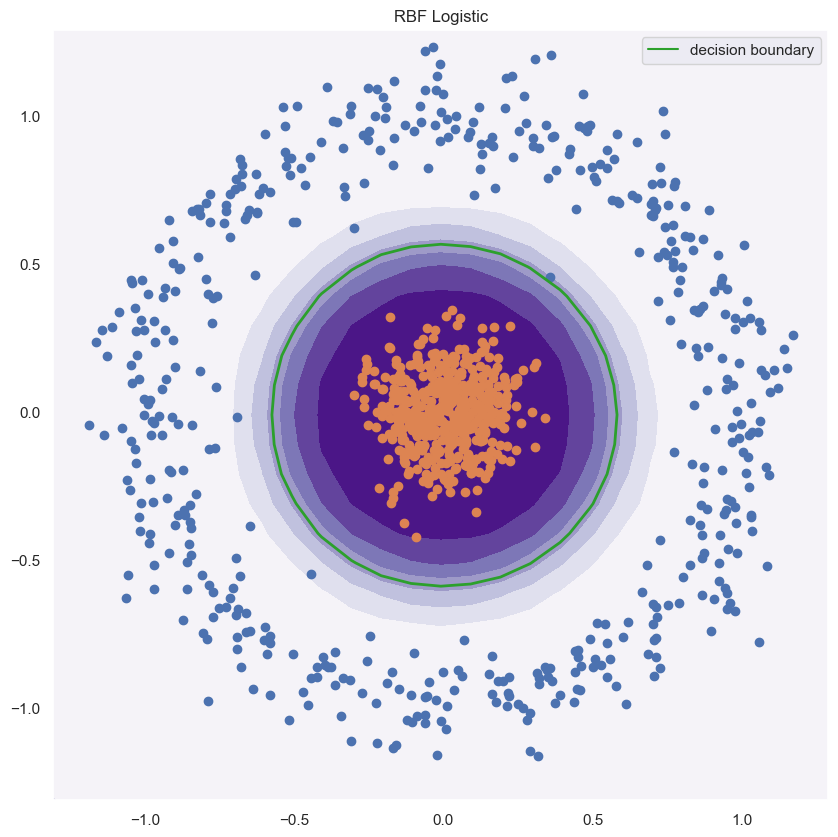

In [9]:
plotLog(linLog,x,y,'Linear Logistic')
plotLog(polyLog,x,y,'Polynomial Logistic')
plotLog(rbfLog,x,y,'RBF Logistic')

# Breast Cancer Dataset

In [84]:
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing
data = load_breast_cancer()
x, y = data.data, data.target
x = preprocessing.normalize(x)
print(x.shape)

x, X_test, y, y_test = train_test_split(x, y, test_size=100, random_state=2)
x, X_val, y, y_val = train_test_split(x, y, test_size=50, random_state=1)
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)


(569, 30)


In [85]:
linLog=LogReg(x,kernel='linear')
linLog.train(x,y,X_val,y_val)
linLog.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.46
Validation Accuracy at epoch 100 : 0.54
Validation Accuracy at epoch 200 : 0.54
Validation Accuracy at epoch 300 : 0.54
Validation Accuracy at epoch 400 : 0.54
Validation Accuracy at epoch 500 : 0.54
Validation Accuracy at epoch 600 : 0.54
Validation Accuracy at epoch 700 : 0.54
Validation Accuracy at epoch 800 : 0.54
Validation Accuracy at epoch 900 : 0.54
Training Loss is : 0.6463668942451477
Test Accuracy: 0.62


In [88]:
polyLog=LogReg(x,kernel='poly',p=5)
polyLog.train(x,y,X_val,y_val)
polyLog.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.54
Validation Accuracy at epoch 100 : 0.54
Validation Accuracy at epoch 200 : 0.54
Validation Accuracy at epoch 300 : 0.54
Validation Accuracy at epoch 400 : 0.54
Validation Accuracy at epoch 500 : 0.54
Validation Accuracy at epoch 600 : 0.54
Validation Accuracy at epoch 700 : 0.54
Validation Accuracy at epoch 800 : 0.54
Validation Accuracy at epoch 900 : 0.54
Training Loss is : 36.038185119628906
Test Accuracy: 0.62


In [87]:
rbfLog=LogReg(x,kernel='rbf')
rbfLog.train(x,y,X_val,y_val)
rbfLog.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.54
Validation Accuracy at epoch 100 : 0.54
Validation Accuracy at epoch 200 : 0.54
Validation Accuracy at epoch 300 : 0.54
Validation Accuracy at epoch 400 : 0.54
Validation Accuracy at epoch 500 : 0.54
Validation Accuracy at epoch 600 : 0.54
Validation Accuracy at epoch 700 : 0.54
Validation Accuracy at epoch 800 : 0.54
Validation Accuracy at epoch 900 : 0.54
Training Loss is : 0.6225431561470032
Test Accuracy: 0.62
